# Predicció de notes per fer recomanació de matrícules

El nostre objectiu d'aquest notebook és fer un ranking de notes basats amb un algoritme de predicció. Tenim un conjunt de dades normalitzades i unes altres no normalitzades, totes les proves les farem amb els dos conjunts. Hem creat un recomanador propi i l'hem integrat amb l'interfaç d'sklearn per així poder testejar de la mateixa manera que fem amb altres algoritmes d'aquesta llibreria. 

In [1]:
%matplotlib inline
from IPython.display import display
import numpy as np
import pandas as pd
import math
import random as rnd
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import seaborn as sbn

#import from utils
import sys
sys.path.append('../')
from utils import *

reg = pd.read_csv("../../../registers.csv", na_values=np.nan)
assig = pd.read_csv("../../../assigs.csv", na_values=np.nan)
conv = pd.read_csv("../../../conv.csv", na_values=np.nan)
qual = pd.read_csv("../../../qualifications.csv", na_values=np.nan)
qual_norm = pd.read_csv("../../../qualifications_normalized.csv", na_values=np.nan)

reg_info = reg[reg['id_enseny'] != 'G1042']
assig_info = assig[assig['id_enseny_assig'] != 'G1042']

df_info = pd.merge(pd.merge(qual, assig_info), reg_info)
df_info_norm = pd.merge(pd.merge(qual_norm, assig_info), reg_info)

In [2]:
# Primer del grau d'Enginyeria Informàtica
# * PROGRAMACIÓ I                -> 364288
# * DISSENY DIGITAL BÀSIC        -> 364289
# * INTRODUCCIÓ ALS ORDINADORS   -> 364290
# * ÀLGEBRA                      -> 364291
# * CÀLCUL                       -> 364292
# * MATEMÀTICA DISCRETA          -> 364293
# * FÍSICA                       -> 364294
# * ALGORÍSMICA                  -> 364298
# * PROGRAMACIÓ II               -> 364299
# * ESTRUCTURA DE DADES          -> 364301

# Segon del grau d'Enginyeria Informàtica
# * ELECTRÒNICA                              -> 364297
# * ALGORÍSMICA AVANÇADA                     -> 364300
# * DISSENY DE SOFTWARE                      -> 364303
# * ESTRUCTURA DE COMPUTADORS                -> 364305
# * INTRODUCCIÓ A LA COMPUTACIÓ CIENTÍFICA   -> 364302
# * EMPRESA                                  -> 364296
# * PROBABILITATS I ESTADÍSTICA              -> 364295
# * PROGRAMACIÓ D'ARQUITECTURES ENCASTADES   -> 364306
# * PROJECTE INTEGRAT DE SOFTWARE            -> 364304
# * SISTEMES OPERATIUS I                     -> 364307

# Tercer del grau d'Enginyeria Informàtica
# INTEL·LIGÈNCIA ARTIFICIAL              -> 364314
# SISTEMES OPERATIUS II                  -> 364308
# TALLER DE NOUS USOS DE LA INFORMÀTICA  -> 364322
# VISIÓ ARTIFICIAL                       -> 364315
# XARXES                                 -> 364309
# BASES DE DADES                         -> 364311
# FACTORS HUMANS I COMPUTACIÓ            -> 364323
# GRÀFICS I VISUALITZACIÓ DE DADES       -> 364328
# LÒGICA I LLENGUATGES                   -> 364310
# SOFTWARE DISTRIBUÏT                    -> 364312

assigs1_lbl = ['P1', 'DDB', 'IO', 'ALGE', 'CAL', 'MD', 'FIS', 'ALGO', 'P2', 'ED']
assigs2_lbl = ['ELEC', 'AA', 'DS', 'EC', 'ICC', 'EMP', 'PIE', 'PAE', 'PIS', 'SO1']
assigs3_lbl = ['IA', 'SO2', 'TNUI', 'VA', 'XAR', 'BD', 'FHIC', 'GiVD', 'LIL', 'SWD']

assigs1 = [364288, 364289, 364290, 364291, 364292, 364293, 364294, 364298, 364299, 364301]
assigs2 = [364297, 364300, 364303, 364305, 364302, 364296, 364295, 364306, 364304, 364307]
assigs3 = [364314, 364308, 364322, 364315, 364309, 364311, 364323, 364328, 364310, 364312]
assigs = assigs1 + assigs2 + assigs3

In [3]:
recomender_table = table_students(df_info, assigs)
recomender_table_norm = table_students(df_info_norm, assigs)

#No normalized data
primer = recomender_table[assigs1]
segon = recomender_table[assigs2]

primer_segon = recomender_table[assigs1 + assigs2]
tercer = recomender_table[assigs3]

#Normalized data
primer_norm = recomender_table_norm[assigs1]
segon_norm = recomender_table_norm[assigs2]

primer_segon_norm = recomender_table_norm[assigs1 + assigs2]
tercer_norm = recomender_table_norm[assigs3]

In [4]:
def coefPearson(x, y):
    x = np.array(x)
    x = x.reshape(x.size)
    y = np.array(y)
    y = y.reshape(y.size)
    length = len(x)
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    x_2 = y_2 = xy =0
    for i in range(length):#apliquem la fórmula del coeficient de pearson
        x_menys_mean = x[i]-x_mean
        y_menys_mean = y[i]-y_mean
        xy += (x_menys_mean)*(y_menys_mean)
        x_2 += x_menys_mean**2
        y_2 += y_menys_mean**2
    square = math.sqrt(x_2*y_2)
    if square == 0:#si square es 0 retornem 0 perquè no doni error
        return 0
    coef = float(xy)/square
    return abs(coef)

### Construcció d'un recomanador amb l'interfaç d'sklearn

Construïm un recomanador on el seu input es una matriu de NxM (alumne x assignatura, o viceversa). D'aquesta matriu agafa totes aquelles cel·les que tenen un NaN (np.nan) i prediu quina nota hauria d'anar, seguint la següent fórmula:

$$m_{a_qe_p} = \sum_{j=1}^n{\alpha_{e_pe_j}m_{a_qe_j}}$$

On:
 * $e_i$ és un estudiant
 * $a_i$ és una assignatura
 * $\alpha$ és una funció de similitud
 
Aquesta fórmula no és més que una suma ponderada, resumint, si un alumne s'assembla molt a un altre, tendiran a tenir les mateixes notes.

La aventatge que té aquest algoritme es que si transposem la matriu $m$, en comptes de tenir un recomanador col·laboratiu, tenim un recomanador basat en contingut.

A partir d'aquí hem de encapsular tot això dintre d'un estimador d'sklearn, per això hem d'heredar de `BaseEstimator` i implementar els mètodes `fit` i `predict`.

In [5]:
class Recomender(BaseEstimator):
    def __init__(self, method=coefPearson, transpose=False):
        self._m = None
        self._method = method
        self._transpose = transpose
        
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self._m = np.concatenate((X,y), axis=1)
        return self
    
    def predict(self, X):
        X = np.array(X)
        if len(X.shape) == 1:
            X = np.array([X])
        nan = [np.nan for i in xrange(self._m.shape[1] - X.shape[1])]
        out = np.array([])
        for xi in X:
            m = np.array(self._m)
            row = np.concatenate((xi,nan),axis=1)
            m = np.vstack((m, row))
            if self._transpose:
                m = m.T
            m_predict, idx = self._recomender(m)
            if out.shape[0] == 0:
                out = np.array([[m_predict[tuple(i)] for i in idx]])
            else:
                out = np.vstack((out, [m_predict[tuple(i)] for i in idx]))
        return out
        
    def _recomender(self, m):
        out = np.array(m)
        idx = np.argwhere(np.isnan(m))
        for i in idx:
            out[tuple(i)] = 0
            sim_sum = 0
            cols = np.argwhere(~np.isnan(m[i[0]])).T[0]

            student = m[i[0]]
            for j in range(m.shape[0]):
                cols= list(set(cols).intersection(np.argwhere(~np.isnan(m[j])).T[0]))
                if np.isnan(m[j,i[1]]) or j == i[0]:
                    continue
                alpha = self._method(student[cols], m[j,cols])
                sim_sum += alpha
                out[tuple(i)] += alpha*m[j,i[1]]
            out[tuple(i)] /= sim_sum
        return out, idx

Ara provarem el nostre recomanador basat en contingut, és a dir, en assignatures.
Per començar provem de predir les notes d'un alumne amb un expedient excel·lent, d'aquest podrem veure que treu bones notes en tot.
Ara bé, que passa si un altre alumne treu males notes a les assignatures de programació?
* **'Programació I'**        - 0.5
* **'Algorítmica'**          - 3.4
* **'Programació II'**       - 1.2
* **'Estructura de Dades'**  - 0.7

In [6]:
to_predict = [[9.00, 9.00, 9.00, 9.00, 9.3, 9.00, 7.70, 9.10, 9.30, 7.40],
              [0.50, 9.00, 9.00, 9.00, 9.3, 9.00, 7.70, 3.4, 1.2, 0.7]]
recomender = Recomender(transpose=True)
recomender.fit(primer.values, segon.values)

predicted = recomender.predict(to_predict)
print "real notes\t|\tpredictions"
for v in range(len(to_predict)):
    print "--------------------------------------"
    z1 = zip(assigs1_lbl, to_predict[v])
    z2 = zip(assigs2_lbl, predicted[v])
    z = zip(z1, z2)
    for i,j in z:
        print "%s\t%.2f\t|\t%s\t%.2f" % (i[0],i[1],j[0],j[1])

real notes	|	predictions
--------------------------------------
P1	9.00	|	ELEC	8.82
DDB	9.00	|	AA	8.87
IO	9.00	|	DS	8.71
ALGE	9.00	|	EC	8.91
CAL	9.30	|	ICC	8.81
MD	9.00	|	EMP	8.81
FIS	7.70	|	PIE	8.90
ALGO	9.10	|	PAE	8.92
P2	9.30	|	PIS	8.66
ED	7.40	|	SO1	8.92
--------------------------------------
P1	0.50	|	ELEC	6.00
DDB	9.00	|	AA	7.24
IO	9.00	|	DS	3.41
ALGE	9.00	|	EC	7.99
CAL	9.30	|	ICC	7.09
MD	9.00	|	EMP	5.63
FIS	7.70	|	PIE	7.58
ALGO	3.40	|	PAE	7.58
P2	1.20	|	PIS	2.52
ED	0.70	|	SO1	6.73


Es veu com en les assignatures de segon que no estan molt relacionades amb les suspeses a primer no es veuen afectades, però tant 'Disseny de Software' i 'Projecte integrat de software' surten suspeses. Per tant, ja el mateix recomanador ens diu les **depèndencies d'assignatures**.

### Testeig

Defineixo diferents tècniques:
 * Recomanador col·laboratiu (alumnes)
 * Recomanador basat en contingut (assignatures)
 * Random Forest Regressor (regressor)
 * Linear Regression (regressor)
 
Per cada tècnica mesurem:
 * MAE (Error promig absolut): $$ \mathrm{MAE} = \frac{1}{n}\sum_{i=1}^n \left| y_{pred}-y_{test}\right|$$
 * MSE (Error promig quadràtic): $$\mathrm{MSE}=\frac{1}{n}\sum_{i=1}^n(y_{pred}-y_{test})^2$$
 * PCC (Coeficient de pearson): $$\mathrm{PCC} =\left| \frac{\sum_{i=1}^n(y_{pred} - \bar{y}_{pred})(y_{test} - \bar{y}_{test})}{\sqrt{\sum_{i=1}^n(y_{pred} - \bar{y}_{pred})^2  \sum_{i=1}^n(y_{test} - \bar{y}_{test})^2}}\right|$$
 

In [7]:
def benchmark(X,y,estimator):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    r = np.abs(y_pred - y_test)
    print "MAE (Mean Absolut Error):             %.3f" % r.mean()
    print "MSE (Mean Squared Error):             %.3f" % mean_squared_error(y_pred, y_test)
    print "PCC (Pearson Correlation Coeficient): %.3f" % coefPearson(y_pred, y_test)
    print "Std (Standard desviation):            %.3f" % r.std()
    return r.reshape(r.size)

In [8]:
estimators = [Recomender(),
              Recomender(transpose=True), 
              RandomForestRegressor(n_estimators=100, random_state=42), #42, magic number
              LinearRegression()]
estimators_lbl = ['RCxE', # Recomanador col·laboratiu per estudiant
                  'RCxA', # Recomanador col·laboratiu per assignatura
                  'RFR',  # Regressor Random Forest
                  'LR']   # Regressor lineal

#### Notes sense normalitzar

Train: primer
Test:  segon
_________________________________________________________________

Estimator: RCxE
MAE (Mean Absolut Error):             1.011
MSE (Mean Squared Error):             2.191
PCC (Pearson Correlation Coeficient): 0.303
Std (Standard desviation):            1.081

Estimator: RCxA
MAE (Mean Absolut Error):             0.916
MSE (Mean Squared Error):             1.760
PCC (Pearson Correlation Coeficient): 0.515
Std (Standard desviation):            0.960

Estimator: RFR
MAE (Mean Absolut Error):             0.979
MSE (Mean Squared Error):             1.975
PCC (Pearson Correlation Coeficient): 0.457
Std (Standard desviation):            1.008

Estimator: LR
MAE (Mean Absolut Error):             0.849
MSE (Mean Squared Error):             1.732
PCC (Pearson Correlation Coeficient): 0.537
Std (Standard desviation):            1.006



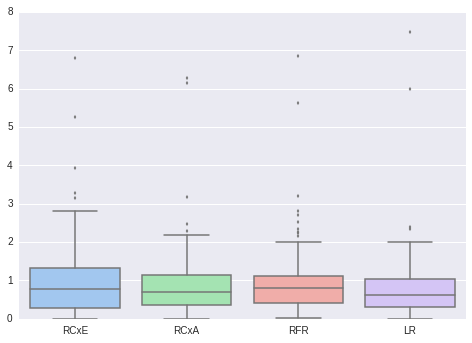

In [9]:
print "Train: primer"
print "Test:  segon"
print "_________________________________________________________________"
print
rs = []
for lbl,e  in zip(estimators_lbl, estimators):
    print "Estimator:", lbl
    rs.append(benchmark(primer.values, segon.values, e))
    print
sbn.boxplot(rs, color='pastel', names=estimators_lbl)
sbn.despine(trim=True)

Train: primer + segon
Test:  tercer
_________________________________________________________________

Estimator: Recomender(method=None, transpose=None)
MAE (Mean Absolut Error):             0.903
MSE (Mean Squared Error):             1.442
PCC (Pearson Correlation Coeficient): 0.142
Std (Standard desviation):            0.792

Estimator: Recomender(method=None, transpose=None)
MAE (Mean Absolut Error):             0.798
MSE (Mean Squared Error):             1.004
PCC (Pearson Correlation Coeficient): 0.458
Std (Standard desviation):            0.606

Estimator: RandomForestRegressor(bootstrap=True, compute_importances=None,
           criterion='mse', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
           min_samples_split=2, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0)
MAE (Mean Absolut Error):             0.790
MSE (Mean Squared Error):             1.170
PCC (Pearson Correlation Co

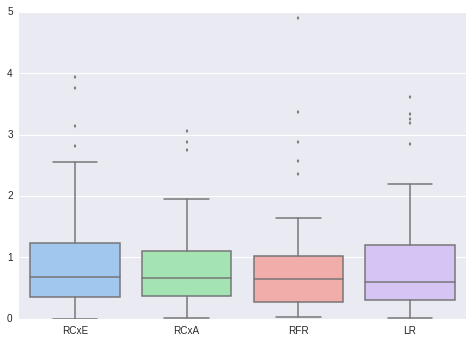

In [10]:
print "Train: primer + segon"
print "Test:  tercer"
print "_________________________________________________________________"
print
rs = []
for e  in estimators:
    print "Estimator:", e
    rs.append(benchmark(primer_segon.values, tercer.values, e))
    print
sbn.boxplot(rs, color='pastel', names=estimators_lbl)
sbn.despine(trim=True)

#### Notes normalitzades

Train: primer
Test:  segon
_________________________________________________________________

Estimator: RCxE
MAE (Mean Absolut Error):             0.584
MSE (Mean Squared Error):             1.069
PCC (Pearson Correlation Coeficient): 0.081
Std (Standard desviation):            0.853

Estimator: RCxA
MAE (Mean Absolut Error):             0.569
MSE (Mean Squared Error):             1.056
PCC (Pearson Correlation Coeficient): 0.131
Std (Standard desviation):            0.855

Estimator: RFR
MAE (Mean Absolut Error):             0.501
MSE (Mean Squared Error):             0.777
PCC (Pearson Correlation Coeficient): 0.500
Std (Standard desviation):            0.726

Estimator: LR
MAE (Mean Absolut Error):             0.559
MSE (Mean Squared Error):             1.020
PCC (Pearson Correlation Coeficient): 0.206
Std (Standard desviation):            0.841



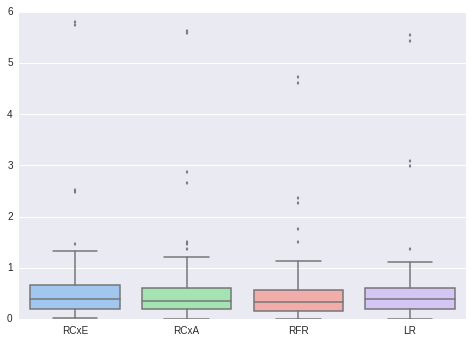

In [11]:
print "Train: primer"
print "Test:  segon"
print "_________________________________________________________________"
print
rs = []
for lbl,e  in zip(estimators_lbl, estimators):
    print "Estimator:", lbl
    rs.append(benchmark(primer_norm.values, segon_norm.values, e))
    print
sbn.boxplot(rs, color='pastel', names=estimators_lbl)
sbn.despine(trim=True)

Train: primer + segon
Test:  tercer
_________________________________________________________________

Estimator: Recomender(method=None, transpose=None)
MAE (Mean Absolut Error):             0.556
MSE (Mean Squared Error):             0.698
PCC (Pearson Correlation Coeficient): 0.329
Std (Standard desviation):            0.624

Estimator: Recomender(method=None, transpose=None)
MAE (Mean Absolut Error):             0.544
MSE (Mean Squared Error):             0.724
PCC (Pearson Correlation Coeficient): 0.379
Std (Standard desviation):            0.654

Estimator: RandomForestRegressor(bootstrap=True, compute_importances=None,
           criterion='mse', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
           min_samples_split=2, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0)
MAE (Mean Absolut Error):             0.530
MSE (Mean Squared Error):             0.774
PCC (Pearson Correlation Co

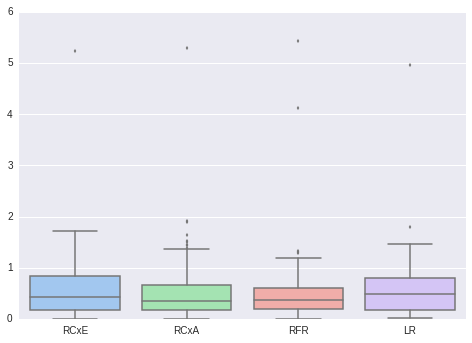

In [12]:
print "Train: primer + segon"
print "Test:  tercer"
print "_________________________________________________________________"
print
rs = []
for e  in estimators:
    print "Estimator:", e
    rs.append(benchmark(primer_segon_norm.values, tercer_norm.values, e))
    print
sbn.boxplot(rs, color='pastel', names=estimators_lbl)
sbn.despine(trim=True)

### Ranking d'assignatures

A partir d'un bon recomanador o regressor, escollit segons el testeig, l'agafem per tal de fer un ranking d'assignatures. La finalitat és que donat un alumne poguem donar un ranking de notes ordenades des de la que li anirà bé fins la que tindrà més problemes.

In [13]:
def ranking_notes(X_train, y_train, X_test, estimator, lbl):
    estimator.fit(X_train, y_train)
    y_pred = np.squeeze(estimator.predict(X_test))
    s = sorted(zip(y_pred,lbl))[::-1]
    return s

In [14]:
# Primer del grau d'Enginyeria Informàtica
# * PROGRAMACIÓ I                -> 364288
# * DISSENY DIGITAL BÀSIC        -> 364289
# * INTRODUCCIÓ ALS ORDINADORS   -> 364290
# * ÀLGEBRA                      -> 364291
# * CÀLCUL                       -> 364292
# * MATEMÀTICA DISCRETA          -> 364293
# * FÍSICA                       -> 364294
# * ALGORÍSMICA                  -> 364298
# * PROGRAMACIÓ II               -> 364299
# * ESTRUCTURA DE DADES          -> 364301

# Segon del grau d'Enginyeria Informàtica
# * ELECTRÒNICA                              -> 364297
# * ALGORÍSMICA AVANÇADA                     -> 364300
# * DISSENY DE SOFTWARE                      -> 364303
# * ESTRUCTURA DE COMPUTADORS                -> 364305
# * INTRODUCCIÓ A LA COMPUTACIÓ CIENTÍFICA   -> 364302
# * EMPRESA                                  -> 364296
# * PROBABILITATS I ESTADÍSTICA              -> 364295
# * PROGRAMACIÓ D'ARQUITECTURES ENCASTADES   -> 364306
# * PROJECTE INTEGRAT DE SOFTWARE            -> 364304
# * SISTEMES OPERATIUS I                     -> 364307

#input
alumne = [7.00, 7.00, 7.00, 1.30, 5.00, 1.20, 1.70, 7.10, 6.30, 6.40]
estimator = Recomender(transpose=False)

# call function
s = ranking_notes(primer.values, segon.values, alumne, estimator, assigs2_lbl)
print "real notes\t|\tpredictions"
print "--------------------------------------"
for (mark1, subject1), (mark2, subject2) in zip(zip(alumne,assigs1_lbl), s):
    print "%.2f - %s\t|\t%.2f - %s" % (mark1, subject1, mark2, subject2)

real notes	|	predictions
--------------------------------------
7.00 - P1	|	7.40 - PAE
7.00 - DDB	|	7.14 - PIS
7.00 - IO	|	7.06 - EMP
1.30 - ALGE	|	6.95 - ELEC
5.00 - CAL	|	6.82 - AA
1.20 - MD	|	6.81 - PIE
1.70 - FIS	|	6.42 - ICC
7.10 - ALGO	|	6.22 - EC
6.30 - P2	|	5.91 - SO1
6.40 - ED	|	5.47 - DS
